In [4]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


/home/student1/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


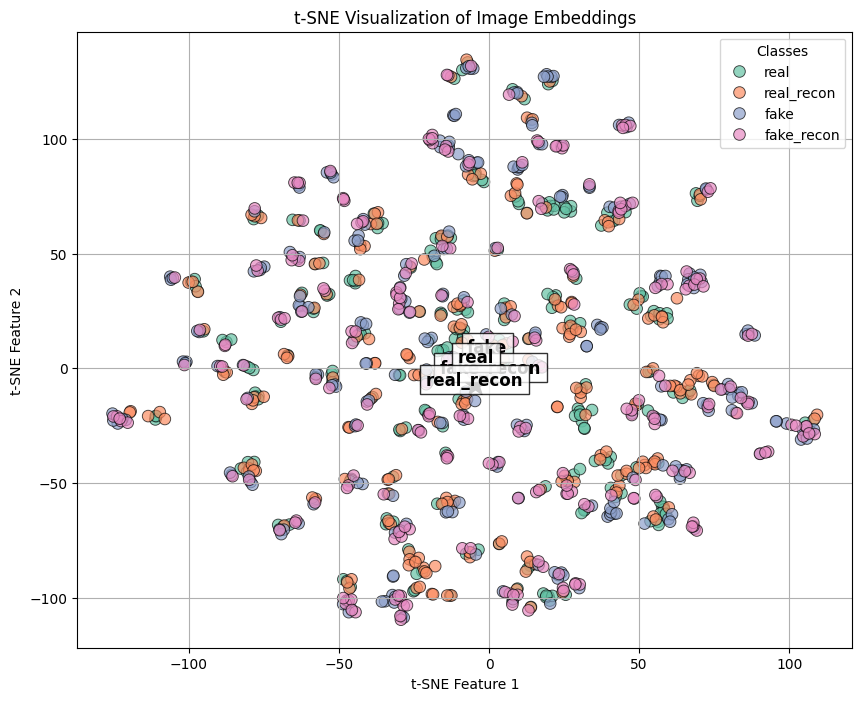

In [10]:
import os
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
from torch.utils.data import DataLoader, Dataset
from network.models import get_models
import random

# 모델 로드
folder_path = '/mnt/work/deepfake_detector/DR/GenImage/stable_diffusion_v_1_4/imagenet_ai_0419_sdv4/train'
model = get_models(model_name="convnext_base_in22k", num_classes=2, embedding_size=1024, freeze_extractor=True)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 이미지 전처리 정의
def create_val_transforms(size=224, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), is_crop=False):
    resize_fuc = A.CenterCrop(height=size, width=size) if is_crop else A.LongestMaxSize(max_size=size)
    return A.Compose([
        A.PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT, value=0) if is_crop else A.NoOp(),
        resize_fuc,
        A.PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

transform = create_val_transforms(size=224, is_crop=False)

# 데이터셋 클래스
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented = self.transform(image=image)
        return augmented["image"], self.labels[idx]

# 클래스 라벨 리스트 매핑
CLASS_LABEL = {
    'ai_crop': 'fake',
    'ai_inpainting': 'fake_recon',
    'nature_crop': 'real',
    'nature_inpainting': 'real_recon'
}

def get_image_files_with_labels(folder_path, extensions=['.jpg', '.jpeg', '.png']):
    image_paths = []
    labels = []

    for category in os.listdir(folder_path):  
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for sub_category in os.listdir(category_path):  
                sub_category_path = os.path.join(category_path, sub_category)
                if os.path.isdir(sub_category_path):
                    key = f"{category}_{sub_category}"
                    if key in CLASS_LABEL:
                        class_label = CLASS_LABEL[key]
                        for file in os.listdir(sub_category_path):
                            if any(file.lower().endswith(ext) for ext in extensions):
                                image_paths.append(os.path.join(sub_category_path, file))
                                labels.append(class_label)
                    else:
                        print(f"Warning: '{key}' not found in CLASS_LABEL")
    
    combined = list(zip(image_paths, labels))
    random.shuffle(combined)
    image_paths, labels = zip(*combined[:1000])

    return list(image_paths), list(labels)

# 이미지 및 라벨 로드
image_paths, labels = get_image_files_with_labels(folder_path)

# 데이터로더 준비
batch_size = 16
dataset = ImageDataset(image_paths, labels, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# 임베딩 추출 함수
def extract_embeddings(model, dataloader):
    real_embeddings, real_recon_embeddings = [], []
    fake_embeddings, fake_recon_embeddings = [], []

    with torch.no_grad():
        for images, batch_labels in dataloader:
            images = images.to(device)

            # 모델에서 임베딩 추출
            features = model(images, return_feature=True)[1].unsqueeze(1)  # [batch_size, 1, embedding_size]

            for i, label in enumerate(batch_labels):
                if label == 'real':
                    real_embeddings.append(features[i].cpu().numpy())
                elif label == 'real_recon':
                    real_recon_embeddings.append(features[i].cpu().numpy())
                elif label == 'fake':
                    fake_embeddings.append(features[i].cpu().numpy())
                elif label == 'fake_recon':
                    fake_recon_embeddings.append(features[i].cpu().numpy())

    return (
        np.concatenate(real_embeddings, axis=0),
        np.concatenate(real_recon_embeddings, axis=0),
        np.concatenate(fake_embeddings, axis=0),
        np.concatenate(fake_recon_embeddings, axis=0),
    )

# 임베딩 추출
real_emb, real_recon_emb, fake_emb, fake_recon_emb = extract_embeddings(model, dataloader)

# 임베딩 병합 및 라벨 생성
embeddings = np.vstack([real_emb, real_recon_emb, fake_emb, fake_recon_emb])
labels = (
    ['real'] * len(real_emb) +
    ['real_recon'] * len(real_recon_emb) +
    ['fake'] * len(fake_emb) +
    ['fake_recon'] * len(fake_recon_emb)
)

# t-SNE 적용
perplexity_value = min(5, len(embeddings) // 3)
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42, n_iter=5000)
X_tsne = tsne.fit_transform(embeddings)

# 시각화 준비
unique_labels = sorted(set(labels))
palette = sns.color_palette("Set2", len(unique_labels))

# t-SNE 시각화
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette=palette, s=70, alpha=0.7, edgecolor="k")

# 중심 위치 강조
for label in unique_labels:
    indices = [i for i, lbl in enumerate(labels) if lbl == label]
    mean_x, mean_y = np.mean(X_tsne[indices, 0]), np.mean(X_tsne[indices, 1])
    plt.scatter(mean_x, mean_y, color='black', marker='*', s=250)
    plt.text(mean_x, mean_y, label, fontsize=12, fontweight='bold', ha='center', bbox=dict(facecolor='white', alpha=0.8))

plt.title("t-SNE Visualization of Image Embeddings")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.legend(title="Classes")
plt.grid(True)
plt.show()


In [9]:
embeddings.shape

(1000, 1024)

In [5]:
import os
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
from network.models import get_models   
from sklearn.decomposition import PCA


# 모델 불러오기
folder_path = '/mnt/work/deepfake_detector/DR/GenImage/stable_diffusion_v_1_4/imagenet_ai_0419_sdv4/train'
model = get_models(model_name="convnext_base_in22k", num_classes=2, embedding_size=1024, freeze_extractor=True)

# 이미지 전처리 함수 정의
def create_val_transforms(size=224, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), is_crop=False):
    resize_fuc = A.CenterCrop(height=size, width=size) if is_crop else A.LongestMaxSize(max_size=size)
    return A.Compose([
        A.PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT, value=0) if is_crop else A.NoOp(),
        resize_fuc,
        A.PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

# 변환 정의
transform = create_val_transforms(size=224, is_crop=False)

# 이미지 전처리 함수 적용
def preprocess_image(image_path, transform):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    augmented = transform(image=image)
    tensor_image = augmented["image"].unsqueeze(0)  # 배치 차원 추가
    
    return tensor_image

# 클래스 라벨 리스트 매핑
CLASS_LABEL = {
    'ai_crop': 'fake',
    'ai_inpainting': 'fake_recon',
    'nature_crop': 'real',
    'nature_inpainting': 'real_recon'
}

# 폴더에서 이미지 파일 가져오기
import random

def get_image_files_with_labels(folder_path, extensions=['.jpg', '.jpeg', '.png']):
    image_paths = []
    labels = []
    
    for category in os.listdir(folder_path):  
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for sub_category in os.listdir(category_path):  
                sub_category_path = os.path.join(category_path, sub_category)
                if os.path.isdir(sub_category_path):
                    key = f"{category}_{sub_category}"
                    if key in CLASS_LABEL:
                        class_label = CLASS_LABEL[key]
                        for file in os.listdir(sub_category_path):
                            if any(file.lower().endswith(ext) for ext in extensions):
                                image_paths.append(os.path.join(sub_category_path, file))
                                labels.append(class_label)
                    else:
                        print(f"Warning: '{key}' not found in CLASS_LABEL")
    
    # 최대 1000개의 샘플 선택 (랜덤 셔플)
    combined = list(zip(image_paths, labels))
    random.shuffle(combined)
    image_paths, labels = zip(*combined[:1000])

    return image_paths, labels

# 모델을 사용한 임베딩 추출
def extract_embeddings(model, folder_path):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    image_paths, labels = get_image_files_with_labels(folder_path)
    embeddings = []

    with torch.no_grad():
        for img_path in image_paths:
            image = preprocess_image(img_path, transform).to(device)
            feature = model(image)  # 모델에서 임베딩 추출
            embeddings.append(feature.cpu().numpy().flatten())

    return np.array(embeddings), labels

# 모델에서 임베딩 추출
embeddings, labels = extract_embeddings(model, folder_path)

# t-SNE 적용
perplexity_value = min(20, len(embeddings) // 3)


tsne = TSNE(n_components=2, perplexity=20, random_state=42, n_iter=5000)
X_tsne = tsne.fit_transform(embeddings)


# 시각화 준비
unique_labels = sorted(set(labels))
palette = sns.color_palette("Set2", len(unique_labels))

# t-SNE 시각화
plt.figure(figsize=(8, 8))
scatter = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette=palette, s=50, alpha=0.7)

# 중심 위치 계산 및 강조
for label in unique_labels:
    indices = [i for i, lbl in enumerate(labels) if lbl == label]
    mean_x, mean_y = np.mean(X_tsne[indices, 0]), np.mean(X_tsne[indices, 1])
    plt.scatter(mean_x, mean_y, color='black', marker='*', s=200)
    plt.text(mean_x, mean_y, label, fontsize=12, fontweight='bold', ha='center', bbox=dict(facecolor='white', alpha=0.6))

plt.title("t-SNE Visualization of Image Embeddings")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.legend(title="Classes")
plt.grid(True)
plt.show()


KeyboardInterrupt: 

In [7]:
embeddings.shape

(1000, 2)

In [25]:
import os
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from PIL import Image
import numpy as np
from network.models import get_models   

# 이미지 폴더 경로
folder_path = '/mnt/work/deepfake_detector/DR/GenImage/stable_diffusion_v_1_4/imagenet_ai_0419_sdv4/train'
model_path = '/mnt/work/deepfake_detector/output/GenImage/2/convnext_base_in22k_224ext_full_drct_17epoch_64/weights/last_acc0.9996.pth'
model = get_models(model_name="convnext_base_in22k", num_classes=2, embedding_size=1024, freeze_extractor=True)
model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=not True)

# 데이터 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 폴더에서 이미지 파일 가져오기
import random

# 클래스 라벨 리스트 매핑
CLASS_LABEL = {
    'ai_crop': 'fake',
    'ai_inpainting': 'fake_recon',
    'nature_crop': 'real',
    'nature_inpainting': 'real_recon'
}

def get_image_files_with_labels(folder_path, extensions=['.jpg', '.jpeg', '.png']):
    image_paths = []
    labels = []
    
    for category in os.listdir(folder_path):  
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for sub_category in os.listdir(category_path):  
                sub_category_path = os.path.join(category_path, sub_category)
                if os.path.isdir(sub_category_path):
                    # 폴더명 조합하여 클래스 매핑
                    key = f"{category}_{sub_category}"
                    if key in CLASS_LABEL:
                        class_label = CLASS_LABEL[key]
                        for file in os.listdir(sub_category_path):
                            if any(file.lower().endswith(ext) for ext in extensions):
                                image_paths.append(os.path.join(sub_category_path, file))
                                labels.append(class_label)
                    else:
                        print(f"Warning: '{key}' not found in CLASS_LABEL")

    return image_paths, labels



# 모델을 사용한 임베딩 추출
def extract_embeddings(model, folder_path):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    image_paths, labels = get_image_files_with_labels(folder_path)
    embeddings = []

    with torch.no_grad():
        for img_path in image_paths:
            image = Image.open(img_path).convert('RGB')
            image = transform(image).unsqueeze(0).to(device)
            
            # 모델에서 임베딩 추출
            feature = model(image)
            embeddings.append(feature.cpu().numpy().flatten())

    return np.array(embeddings), labels


# 모델에서 임베딩 추출
embeddings, labels = extract_embeddings(model, folder_path)

# t-SNE 적용
perplexity_value = min(20, len(embeddings) // 3)
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
X_tsne = tsne.fit_transform(embeddings)

# 시각화 준비
unique_labels = sorted(set(labels))
palette = sns.color_palette("Set2", len(unique_labels))

# t-SNE 시각화
plt.figure(figsize=(8, 8))
scatter = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette=palette, s=50, alpha=0.7)

# 중심 위치 계산 및 강조
for label in unique_labels:
    indices = [i for i, lbl in enumerate(labels) if lbl == label]
    mean_x, mean_y = np.mean(X_tsne[indices, 0]), np.mean(X_tsne[indices, 1])
    plt.scatter(mean_x, mean_y, color='black', marker='*', s=200)
    plt.text(mean_x, mean_y, label, fontsize=12, fontweight='bold', ha='center', bbox=dict(facecolor='white', alpha=0.6))

plt.title("t-SNE Visualization of Image Embeddings")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.legend(title="Classes")
plt.grid(True)
plt.show()


/tmp/ipykernel_551243/3509265086.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=not True)


KeyboardInterrupt: 

In [4]:
embeddings.shape 

(1000, 2)